# Satellite Intelligence for Catastrophic Natural Disaster Recovery: Assessing Damage and First Responder Priorities through Geospatial Imagery

## Jeremiah Fa'atiliga, Ravita Kartawinata, Sowmiya Kanmani Maruthavanan

## Importing Libraries

In [1]:
import os
import json
import pandas as pd
import geopandas as gpd
import numpy as np
import cv2
import boto3
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io
from shapely import wkt
from shapely.geometry import mapping
import geopandas as gpd
from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings("ignore")


# S3 Bucket Download

In [3]:
S3_Bucket_Name = 'hurricaneimagebucket'
Image_Directory = '../Images'
Data_Directory = '../Data'

In [ ]:
# Initialize S3 client
s3_client = boto3.client('s3')

# S3 Bucket Download Function for Images and Data with Pagination
def S3_Download(S3_Bucket_Name, Image_Directory, Data_Directory):
    continuation_token = None

    while True:
        # List objects with pagination
        if continuation_token:
            S3_Response = s3_client.list_objects_v2(Bucket=S3_Bucket_Name, ContinuationToken=continuation_token)
        else:
            S3_Response = s3_client.list_objects_v2(Bucket=S3_Bucket_Name)

        if 'Contents' in S3_Response:
            for S3_Object in S3_Response['Contents']:
                file_name = S3_Object['Key']

                if file_name.endswith('.png'):  # Image file
                    file_path = os.path.join(Image_Directory, file_name)
                elif file_name.endswith('.json'):  # Data file
                    file_path = os.path.join(Data_Directory, file_name)
                else:
                    continue  

                # Create to user path
                os.makedirs(os.path.dirname(file_path), exist_ok=True)

                # Download file to user path
                s3_client.download_file(S3_Bucket_Name, file_name, file_path)

        # Check if there's more data to retrieve
        if S3_Response.get('IsTruncated'): 
            continuation_token = S3_Response['NextContinuationToken']
        else:
            break  

S3_Download(S3_Bucket_Name, Image_Directory, Data_Directory)

In [5]:
image_file_count = sum(len(files) for _, _, files in os.walk(Image_Directory))
data_file_count = sum(len(files) for _, _, files in os.walk(Data_Directory))

print(f"Number of files in {Image_Directory}: {image_file_count}")
print(f"Number of files in {Data_Directory}: {data_file_count}")

Number of files in ../Images: 2444
Number of files in ../Data: 3222


## Loading the images and JSON data

In [8]:
# Function to load pre- and post- disaster images
def load_images(filename) : 
    image_path = os.path.join(Image_Directory, filename)
    # Reading the image
    image = cv2.imread(image_path)
    
    # Convert image from BGR to RGB format
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return rgb_image

The xBD dataset provides annotated high-resolution satellite imagery for assessing building damage, consisting of JSON files and image files. This project focuses on analyzing pre- and post-disaster imagery related to hurricanes.

## Data Translation

In [12]:
# Function to read JSON files
def load_JSON_data(Data_Directory):
    pre_data = []
    post_data = []

    for filename in os.listdir(Data_Directory):
        file_path = os.path.join(Data_Directory, filename)
        
        # Ensure the path is a file, not a directory
        if os.path.isfile(file_path):
            with open(file_path, 'r') as file:
                content = json.load(file)

            # Filter by hurricane natural disaster only
            disaster = content['metadata'].get('disaster')
            if disaster and "hurricane" in disaster.lower():
                img_name = content['metadata'].get('img_name', "")
                data = {
                    'img_name': img_name,
                    'lng_lat': content['features'].get('lng_lat'),
                    'xy': content['features'].get('xy'),
                    'sensor': content['metadata'].get('sensor'),
                    'provider_asset_type': content['metadata'].get('provider_asset_type'),
                    'gsd': content['metadata'].get('gsd'),
                    'capture_date': content['metadata'].get('capture_date'),
                    'off_nadir_angle': content['metadata'].get('off_nadir_angle'),
                    'pan_resolution': content['metadata'].get('pan_resolution'),
                    'sun_azimuth': content['metadata'].get('sun_azimuth'),
                    'sun_elevation': content['metadata'].get('sun_elevation'),
                    'target_azimuth': content['metadata'].get('target_azimuth'),
                    'disaster': disaster,
                    'disaster_type': content['metadata'].get('disaster_type'),
                    'catalog_id': content['metadata'].get('catalog_id'),
                    'original_width': content['metadata'].get('original_width'),
                    'original_height': content['metadata'].get('original_height'),
                    'width': content['metadata'].get('width'),
                    'height': content['metadata'].get('height'),
                    'id': content['metadata'].get('id')
                }
            
            # Separate pre and post DataFrame
            if "pre" in img_name.lower():
                pre_data.append(data)
            elif "post" in img_name.lower():
                post_data.append(data)
    
    hurricane_pre_df = pd.DataFrame(pre_data)
    hurricane_post_df = pd.DataFrame(post_data)
    
    return hurricane_pre_df, hurricane_post_df

In [14]:
Data_Directory = "../Data"
# Loading JSON data into dataframe
hurricane_pre_df, hurricane_post_df = load_JSON_data(Data_Directory)

## Exploration Data Analysis

In [16]:
# Combine pre and post dataframe
hurricane_pre_df['status'] = 'Pre'
hurricane_post_df['status'] = 'Post'
hurricane_df =  pd.concat([hurricane_pre_df, hurricane_post_df])

In [17]:
hurricane_df.describe()

,gsd,off_nadir_angle,pan_resolution,sun_azimuth,sun_elevation,target_azimuth,original_width,original_height,width,height
count,3222.000000,3222.000000,3222.000000,3222.000000,3222.000000,3222.000000,3222.00000,3222.00000,3222.0,3222.0
mean,2.197594,26.604592,0.549695,152.292200,53.871879,169.261383,1024.00869,1024.00869,1024.0,1024.0
std,0.325800,7.143872,0.080885,20.183954,8.952436,106.051850,0.09283,0.09283,0.0,0.0
min,1.503376,9.628279,0.375870,69.757317,35.949000,54.715256,1024.00000,1024.00000,1024.0,1024.0
25%,2.066485,24.512466,0.516751,150.963420,50.756794,58.756830,1024.00000,1024.00000,1024.0,1024.0
50%,2.091625,25.070637,0.522825,158.565308,53.402645,112.555626,1024.00000,1024.00000,1024.0,1024.0
75%,2.221744,28.866730,0.557522,163.238040,55.891373,282.336460,1024.00000,1024.00000,1024.0,1024.0
max,3.146662,44.191100,0.784305,163.926380,74.701843,357.342350,1025.00000,1025.00000,1024.0,1024.0


In [18]:
hurricane_df.shape

(3222, 21)

### Damage Classification by Disaster Type 

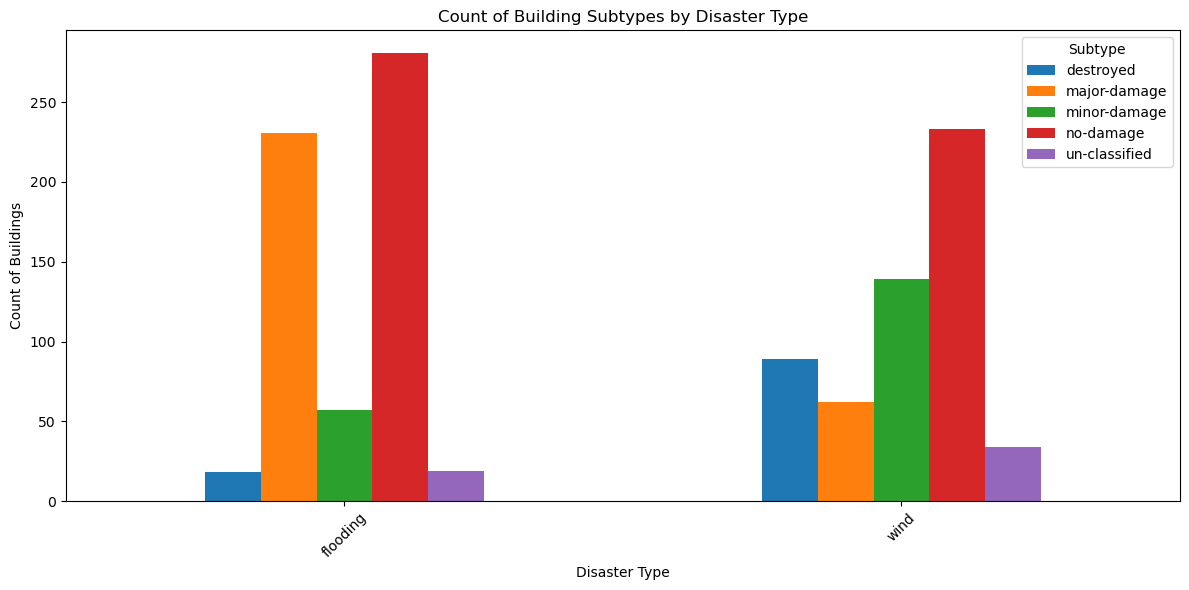

In [20]:
# Extract subtype from xy
hurricane_df['subtype'] = hurricane_df['xy'].apply(
    lambda x: x[0]['properties'].get('subtype') if isinstance(x, list) and len(x) > 0 and 'properties' in x[0] else None
)
counts = hurricane_df.groupby(['disaster_type', 'subtype']).size().unstack(fill_value=0)

# Plotting bar chart for each disaster type
counts.plot(kind='bar', figsize=(12, 6), color=sns.color_palette("Set2", n_colors=len(counts.columns)))
plt.title("Count of Building Subtypes by Disaster Type")
plt.xlabel("Disaster Type")
plt.ylabel("Count of Buildings")
plt.xticks(rotation=45)
plt.legend(title="Subtype")
plt.tight_layout()
plt.show()

The barplot shows the count of buildings impacted by two types of disasters: flooding and wind. It's categorized by damage severity. Each disaster type on the x-axis is broken down into five subtypes of building damage: destroyed, major-damage, minor-damage, no-damage, and unclassified. The tall red bars indicate a high count of buildings that sustained no damage in both flooding and wind events. Major-damage (orange) is also prominent in flooding, while minor-damage (green) is more frequent in wind-related incidents. 
The chart provides insight into how different disaster types impact buildings at varying levels of severity especially the impact of flooding.

### Relationship between Features and Disaster Type/Status 

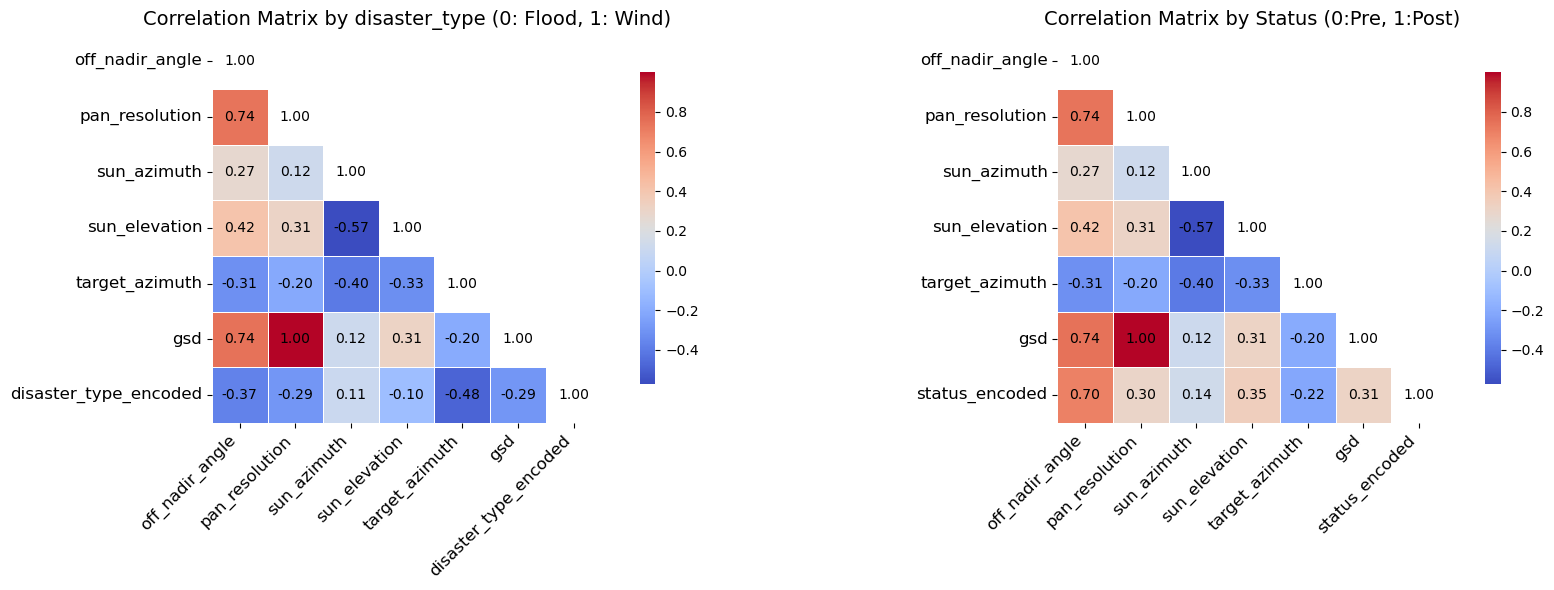

In [64]:
hurricane_df['disaster_type_encoded'] = hurricane_df['disaster_type'].map({'flooding': 0, 'wind': 1})
hurricane_df['status_encoded'] = hurricane_df['status'].map({'Pre': 0, 'Post': 1})
# hurricane_df['subtype_encoded'] = hurricane_df['subtype'].apply(lambda x: 1 if x != 'no-damage' else 0) # SHOULD WE DO THIS????


fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# First plot: Correlation matrix by disaster_type (0: Flood, 1: Wind)
features_disaster = [
    'off_nadir_angle',
    'pan_resolution',
    'sun_azimuth',
    'sun_elevation',
    'target_azimuth',
    'gsd',
    'disaster_type_encoded'
]
correlation_matrix_disaster = hurricane_df[features_disaster].corr()
mask_disaster = np.triu(np.ones_like(correlation_matrix_disaster, dtype=bool))

# First plot: Disaster Type Correlation Matrix
sns.heatmap(
    correlation_matrix_disaster,
    mask=mask_disaster,  
    annot=False, fmt=".2f", cmap='coolwarm', 
    square=True, cbar_kws={"shrink": .8}, ax=axes[0],
    linewidths=0.5, linecolor='white'  
)

for i in range(len(correlation_matrix_disaster.columns)):
    for j in range(len(correlation_matrix_disaster.index)):
        if i >= j:  
            axes[0].text(
                j + 0.5, i + 0.5, 
                f'{correlation_matrix_disaster.iloc[i, j]:.2f}', 
                ha='center', va='center', color='black', fontsize=10
            )

axes[0].set_title('Correlation Matrix by disaster_type (0: Flood, 1: Wind)', fontsize=14)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=12)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0, fontsize=12)

# Second plot: Correlation matrix by Status (Pre/Post)
features_status = [
    'off_nadir_angle',
    'pan_resolution',
    'sun_azimuth',
    'sun_elevation',
    'target_azimuth',
    'gsd',
    'status_encoded'
]
correlation_matrix_status = hurricane_df[features_status].corr()
mask_status = np.triu(np.ones_like(correlation_matrix_status, dtype=bool))

# Second plot: Status Correlation Matrix
sns.heatmap(
    correlation_matrix_status,
    mask=mask_status,  
    annot=False, fmt=".2f", cmap='coolwarm', 
    square=True, cbar_kws={"shrink": .8}, ax=axes[1],
    linewidths=0.5, linecolor='white' 
)

for i in range(len(correlation_matrix_status.columns)):
    for j in range(len(correlation_matrix_status.index)):
        if i >= j:  
            axes[1].text(
                j + 0.5, i + 0.5, 
                f'{correlation_matrix_status.iloc[i, j]:.2f}', 
                ha='center', va='center', color='black', fontsize=10
            )

axes[1].set_title('Correlation Matrix by Status (0:Pre, 1:Post)', fontsize=14)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=12)
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, fontsize=12)

plt.tight_layout()
plt.show()


The two correlation matrices provide valuable information about various satellite observation related to disaster types and statuses natural disasters. The color and values show correlations between each features. Red represents positive correlations, while blue represents negative correlations.

In general, the correlation between numerical features (off_nadir_angle, pan_resolution, gsd) is consistent between these plots:
- Off_nadir_angle and pan_resolution are highly correlated, suggesting that as the angle of the satellite increases from nadir (directly overhead), the spatial resolution of the image may change.
- The angle of the satellite from directly overhead (off_nadir_angle) and the sun’s position above the horizon (sun_elevation) are moderately linked, meaning these factors tend to increase together but not as strongly as above.
- gsd (Ground Sample Distance) is the distance on the ground that each pixel in a satellite image represents. gsd has positive correlation between gsd and off-nadir angle. As the off-nadir angle increases, so does gsd. While gsd and pan_resolution are likely negatively correlated, indicating that as the ground sample distance decreases (higher resolution), the panchromatic resolution increases. 
 
The first plot on the left examines the correlation between features such as off_nadir_angle, pan_resolution, and disaster_type_encoded, which categorizes observations as either flooding (0) or wind (1). .
- Disaster type (disaster_type_encoded) has a weak negative correlation with most factors, like the sun’s angle and the satellite’s angle. This suggests a slight tendency for certain angles and sun positions to differ between wind and flood imagery.
- Disaster type shows a moderate negative correlation with the satellite angle and image resolution, meaning that wind-related images tend to have lower satellite angles and better resolution than flood images.

The second plot on the right focuses on the correlation with status_encoded, indicating observations taken before (0) and after (1) a disaster, allowing for the assessment of changes in features due to the disaster's impact. 
- "off_nadir_angle" has a strong positive correlation with "status_encoded." This suggests that the "off_nadir_angle" tends to increase when the status changes from "Pre" to "Post."
- "pan_resolution" shows a moderate positive correlation with "status_encoded," indicating a slight increase in "pan_resolution" with the status change.
- "sun_azimuth" and "sun_elevation" exhibit weak negative correlations with "status_encoded," suggesting a slight decrease in these variables with the status change.
- "target_azimuth" has a strong negative correlation with "status_encoded," indicating a significant decrease in "target_azimuth" when the status changes from "Pre" to "Post."
- gsd has a moderate positive correlation with "status_encoded, indicating an increasing tendency in "gsd" when the status changes from "Pre" to "Post"

The numerical features do not have a strong correlation with disaster_type_encoded, and in fact, exhibit a negative correlation. Conversely, off_nadir_angle shows a strong correlation with status_encoded (Pre/Post), but displays a negative correlation with the target_azimuth feature.
In addition, when there's high correlation between features in features_status, it might be worth considering feature selection or dimensionality reduction techniques to avoid issues like multicollinearity in modeling.

In [13]:
### Polygon Shape plot sampling before and after disaster

In [14]:
# Sampling hurricane michael pre-post
from shapely.geometry import Polygon
from shapely import wkt as shapely_wkt
filtered_df = hurricane_df[hurricane_df['img_name'].str.contains('hurricane-michael')]
# WKT - Well-known-text text format
filtered_df['wkt_lnglat'] = filtered_df['lng_lat'].apply(
    lambda x: x[0].get('wkt') if isinstance(x, list) and len(x) > 0 else None
)
# Get geometry format by applying Shapely Polygon
filtered_df.loc[:, 'polygon_shape'] = filtered_df['wkt_lnglat'].apply(wkt.loads)

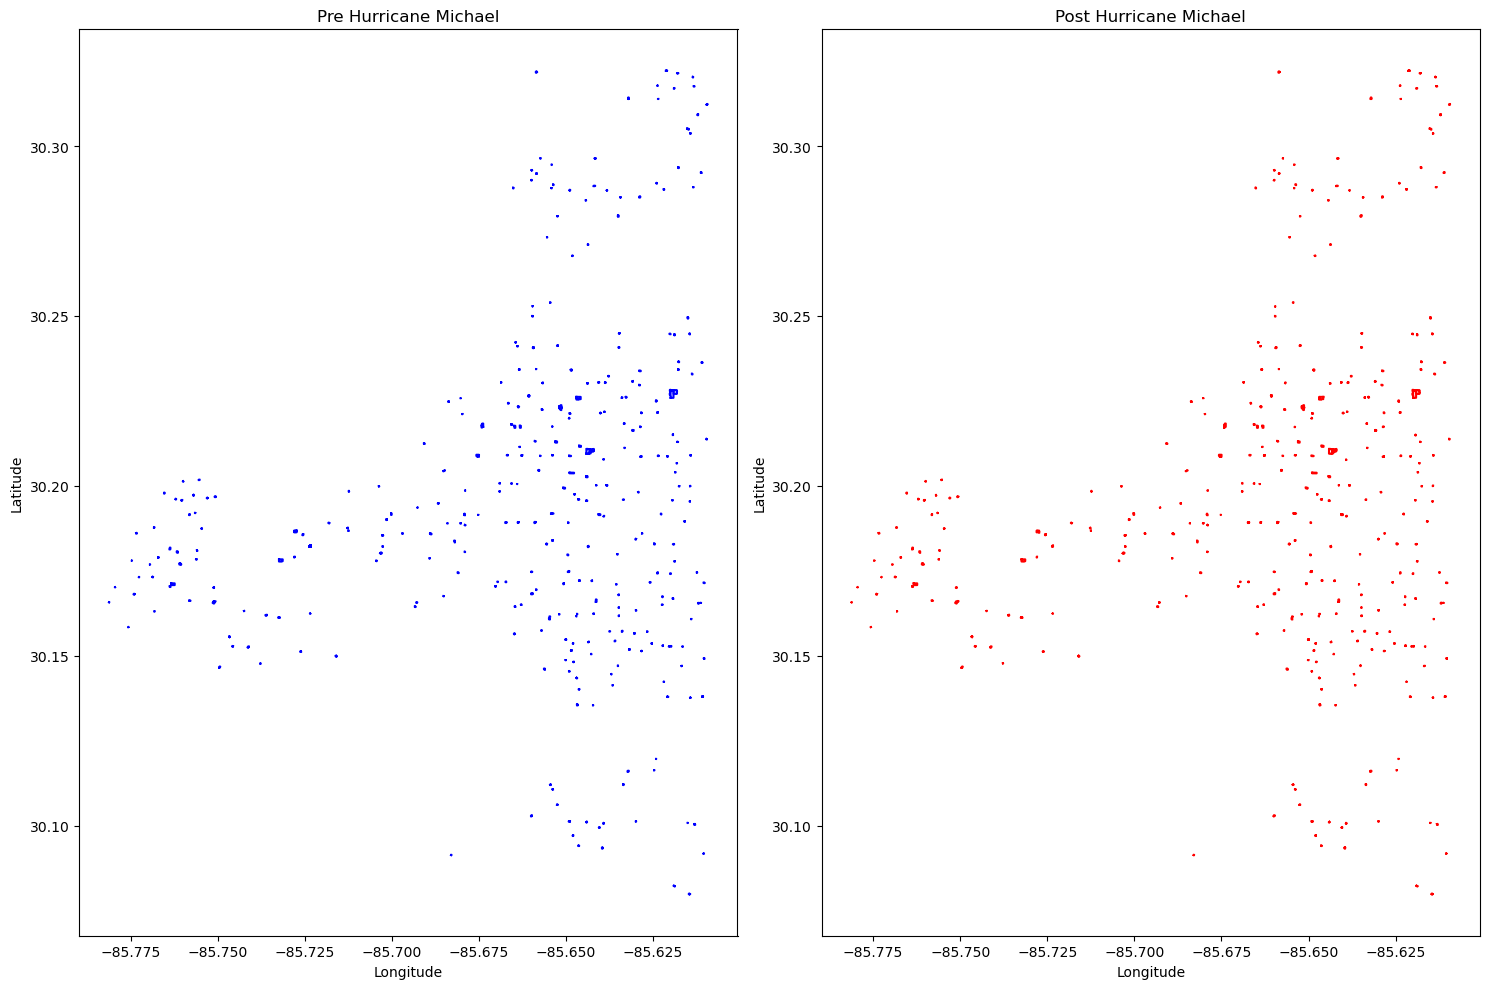

In [15]:
fig, (ax_pre, ax_post) = plt.subplots(1, 2, figsize=(15, 10))

# Plotting Pre Hurricane Data
pre_data = filtered_df[filtered_df['status'] == 'Pre']
for idx, row in pre_data.iterrows():
    if row['polygon_shape'] is not None:
        ax_pre.plot(*row['polygon_shape'].exterior.xy, color='blue', label='Pre' if idx == pre_data.index[0] else "")

ax_pre.set_title('Pre Hurricane Michael')
ax_pre.set_xlabel('Longitude')
ax_pre.set_ylabel('Latitude')

# Plotting Post Hurricane Data
post_data = filtered_df[filtered_df['status'] == 'Post']
for idx, row in post_data.iterrows():
    if row['polygon_shape'] is not None:
        ax_post.plot(*row['polygon_shape'].exterior.xy, color='red', label='Post' if idx == post_data.index[0] else "")
        
ax_post.set_title('Post Hurricane Michael')
ax_post.set_xlabel('Longitude')
ax_post.set_ylabel('Latitude')

# Adjust layout
plt.tight_layout()
plt.show()


The polygon points for post-disaster cannot be used for training the model as they are the same for pre- and post-disaster. It shows that there is very minimum impact on the property structure latitude and longtitude post of hurrican disaster due to flooding or wind.

### Sampling Building Clusters Using DBSCAN

In [16]:
# converts building shapes into geometric objects and creates a GeoDataFrame
filtered_df['geometry_lnglat'] = filtered_df['polygon_shape'].apply(lambda x: Polygon(x))
gdf = gpd.GeoDataFrame(filtered_df, geometry='geometry_lnglat')

# Set the Coordinate Reference System (CRS) - here, WGS84
gdf.crs = 'EPSG:4326'
gdf = gdf.reset_index(drop=True)

<Axes: >

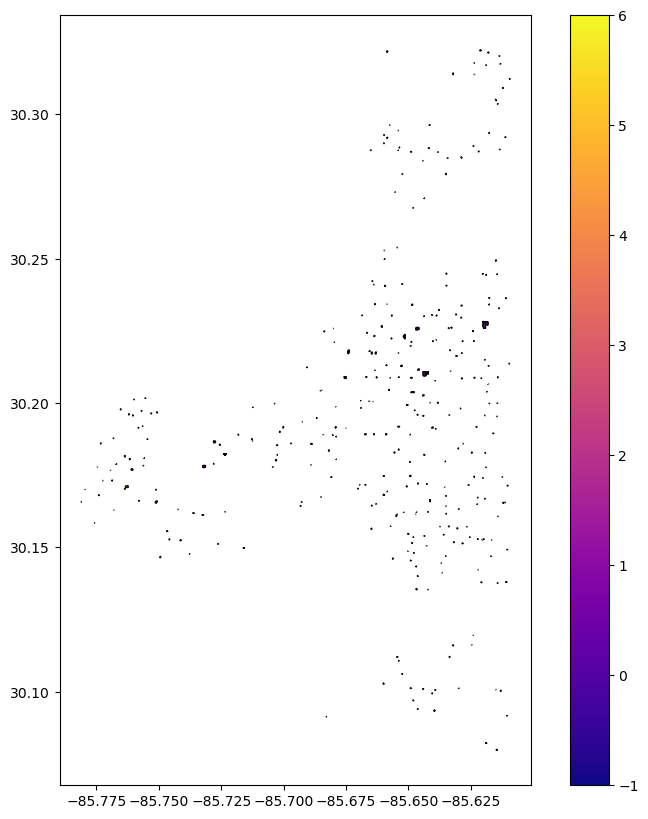

In [17]:
# Calculate the distance matrix (using Euclidean distance)
distance_matrix = gdf.geometry.apply(lambda geom: gdf.distance(geom))

# Fill NaN values and convert distance to 2D np array
distance_matrix = distance_matrix.fillna(distance_matrix.max().max())
distance_matrix_array = distance_matrix.values

# Apply DBSCAN and assign cluster
clustering = DBSCAN(eps=0.01, min_samples=5, metric="precomputed").fit(distance_matrix_array)
gdf['cluster'] = clustering.labels_

gdf.plot(column='cluster', cmap='plasma', legend=True, 
         figsize=(10, 10), edgecolor='black', alpha=0.8)

The purpose is to group similar buildings together based on their latitude/ longtitude. It first identifies the shape and location of each building. Then, it calculates the distance between buildings and groups nearby buildings into clusters (1-6).
The visualization above shows the spatial distribution of buildings. Areas with denser clusters of points indicate higher building density, likely corresponding to urban or suburban areas. The darker clusters in the plot highlight specific areas with significant building concentration. These areas may be of particular interest for first responders on disaster response strategies. Conversely, areas with scattered points suggest less developed or rural regions.

## Loading the images and JSON data

In [18]:
# Function to load pre- and post- disaster images
def load_images(filename) : 
    image_path = os.path.join(Image_Directory, filename)
    # Reading the image
    image = cv2.imread(image_path)
    
    # Convert image from BGR to RGB format
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return rgb_image

In [ ]:
Image_Directory = '../Images/hurricane'

pre_hurricane_images = []
pre_image_size = []

post_hurricance_images = []
post_image_size = []

for index, row in hurricane_pre_df.iterrows() :
    img_filename = row['img_name']
    img = load_images(img_filename)
    size = img.shape
    pre_hurricane_images.append(img)
    pre_image_size.append(size)

for index, row in hurricane_post_df.iterrows() :
    img_filename = row['img_name']
    img = load_images(img_filename)
    size = img.shape
    post_hurricance_images.append(img)
    post_image_size.append(size)

In [ ]:
hurricane_pre_df['image_size'] = pre_image_size
hurricane_post_df['image_size'] = post_image_size

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Display pre-disaster images 
for i in range(3) :
    axes[0, i].imshow(pre_hurricane_images[i])
    axes[0, i].axis('off')

# Display post-disaster images 
for i in range(3) :
    axes[1, i].imshow(post_hurricance_images[i])
    axes[1, i].axis('off')

axes[0,0].set_title("Pre-disaster images")
axes[1,0].set_title("Post-disaster images")
plt.show()